In [ ]:
%matplotlib inline

# Assignment 5

**DUE: Sunday December 4, 2022 11:59pm**

Turn in the assignment via Canvas.

To write legible answers you will need to be familiar with both [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) and [Latex](https://www.latex-tutorial.com/tutorials/amsmath/)

Before you turn this problem in, make sure everything runs as expected. First, restart the kernel (in the menubar, select Runtime→→Restart runtime) and then run all cells (in the menubar, select Runtime→→Run All).

Make sure you fill in any place that says "YOUR CODE HERE" or "YOUR ANSWER HERE", as well as your name below:

In [ ]:
NAME = "Mahyar Vahabi"
STUDENT_ID = "1798645"

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras import layers, losses, metrics
from keras.models import *
from keras.layers import *
from keras.losses import *
from keras.metrics import *
from keras.datasets import *


## Question 1: Bitcoin Price Prediction
---
Bitcoin, amongst other assets like AMC and GME, has been all the rage this past two years and reached an all time high of \$68,789.63 per bitcoin. Since reaching it's high, the price has dropped 75\%. Analysts continue to feed the frenzy by releasing price predictions that range from from \$500,000 to \$9,000 per bitcoin in the next year. You will make an Recurrent Neural Network model to gain some insight into price prediction. Yahoo! Finance is a trusted name in free financial information and has been with us since the internet's early years. You'll be using data gathered obtained from https://finance.yahoo.com/quote/BTC-USD/history/ to train your recurrent neural network.

Run the following code cell to download the training and test data. It might take a while to download the zip file and extract it.

Link to the raw data: [link](https://drive.google.com/file/d/1GqHXiTMdWfNniUfF0B5TkKnvMSV1kI4b)

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import io
import zipfile
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id = '1GqHXiTMdWfNniUfF0B5TkKnvMSV1kI4b'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('BTC-USD.csv')


In [ ]:
# Create pandas dataframe
data = pd.read_csv('BTC-USD.csv')

In [ ]:
# Plot data.head()
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0


Let's plot the bitcoin price. First, we will make a plot of bitcoin price vs the days after September 15, 2014, the start date of this dataset. Day "0" indicates September 15, 2014.

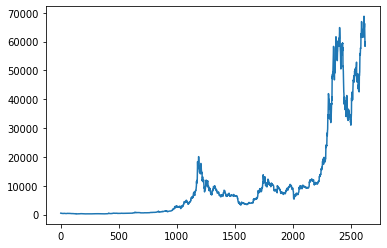

In [ ]:
g = sns.lineplot(x = np.linspace(1,2622,2622), y = data['High'].values.reshape(-1))

Next, we plot bitcoin vs. days. But this time there are dates added to the graph.

[Text(0, 0, '2014-09-17'),
 Text(0, 0, '2015-04-05'),
 Text(0, 0, '2015-10-22'),
 Text(0, 0, '2016-05-09'),
 Text(0, 0, '2016-11-25'),
 Text(0, 0, '2017-06-13'),
 Text(0, 0, '2017-12-30'),
 Text(0, 0, '2018-07-18'),
 Text(0, 0, '2019-02-03'),
 Text(0, 0, '2019-08-22'),
 Text(0, 0, '2020-03-09'),
 Text(0, 0, '2020-09-25'),
 Text(0, 0, '2021-04-13')]

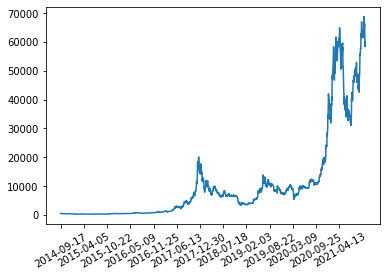

In [ ]:
g = sns.lineplot(x = np.linspace(1,2622,2622), y = data['High'].values.reshape(-1))
g.set(xticks=np.arange(0,2500,200))
g.set_xticklabels(rotation=30, labels = data['Date'][0::200])

### Part a) Data Preprocessing (5 points)
In this section you will preprocess the data in order to train a recurrent neural network. We can see that there 5 columns, "Date", "Open", "High", "Low", "Close", "Adjusted Close", and "Volume". We will only use the High column.

In [ ]:
# Create a dataframe that only contains High Column.
# Hint: it may be helpful to now cast your pruned dataframe to a numpy array.

data_high = data[['High']].copy()
### YOUR CODE HERE ###

In [ ]:
data_high

,High
0,468.174011
1,456.859985
2,427.834991
3,423.295990
4,412.425995
...,...
2617,63721.195313
2618,60823.609375
2619,60948.500000
2620,58351.113281


Remove missing values from the data.

In [ ]:
# Remove enteries from the data with missing values. 
# The shape of the data after this step shoud be (2618,)

data_high = data_high.dropna()
### YOUR CODE HERE ###

In [ ]:
data_high

,High
0,468.174011
1,456.859985
2,427.834991
3,423.295990
4,412.425995
...,...
2617,63721.195313
2618,60823.609375
2619,60948.500000
2620,58351.113281



Recall [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) from sklearn. Use it to scale the data for our analysis. 

In [ ]:
### YOUR CODE HERE ###
scaler = MinMaxScaler()
### YOUR CODE HERE ###

data_normalized = scaler.fit_transform(data_high.values.reshape((-1, 1)))
### YOUR CODE HERE ###

You will implement a simple autoregressive recurrent neural network using the standard tensorflow RNN architectures. An autoregressive model originates from the literature on time-series models where observations from the previous time-steps are used to predict the value at the current time step. To implemement an autoregressive model, we will simply augment the data so that "time_steps" number of previous days are fed to the model at the current time step in order to form a prediction. The function to augment the data is given to you:

In [ ]:
def create_dataset(dataset, time_steps=1):
    """
    Generate a dataset where the time series X[n] contains the readings for the 'time_step' previous days 
    and y contains the price for today.
    args:
    dataset: numpy array, the data
    time_steps: the number of previous days to feed to RNN

    returns:
    tuple: a dataset with x[i] containing 'time_step' number of previous prices, target price for x[i]
    """
    dataX, dataY = [],[]
    for i in range(len(dataset)-time_steps-1):
        a = dataset[i:(i+time_steps)]
        dataX.append(a)
        dataY.append(dataset[i + time_steps])
    return np.array(dataX), np.array(dataY)

In [ ]:
# Choose the number of time steps that the model "looks back"
time_steps = 4
### YOUR CODE HERE ###

# Produce your dataset based on the number of days the model could look back

### YOUR CODE HERE ###
X, y = create_dataset(data_normalized, time_steps)

In [ ]:
print(X, y)

[[[0.00373944]
  [0.00357446]
  [0.00315122]
  [0.00308503]]

 [[0.00357446]
  [0.00315122]
  [0.00308503]
  [0.00292653]]

 [[0.00315122]
  [0.00308503]
  [0.00292653]
  [0.00284618]]

 ...

 [[0.94351023]
  [0.95196054]
  [0.96342765]
  [0.92609237]]

 [[0.95196054]
  [0.96342765]
  [0.92609237]
  [0.88383989]]

 [[0.96342765]
  [0.92609237]
  [0.88383989]
  [0.88566104]]] [[0.00292653]
 [0.00284618]
 [0.00335131]
 ...
 [0.88383989]
 [0.88566104]
 [0.84778606]]


In [ ]:
# Check the shape of your dataset; should be (2618-time_steps-1, time_steps) and (2618-time_steps-1,)
print(X.shape, y.shape)

(2613, 4, 1) (2613, 1)


### Part b) Data Partitioning (5 points)
Split data into train and test sets. Use 80\% for training and 20\% for testing. **Note**: you need to split the data in time (the begining 80\% of the days from start date will be the training data and the remaining 20\% will be test data).

In [ ]:
### YOUR CODE HERE ###
train_size = int(len(X) * 0.8)
test_size = len(data_normalized) - train_size - 2*time_steps

X_train, X_test = X[0: train_size, :], X[train_size: len(data_normalized), :]
y_train, y_test = y[0: train_size, :], y[train_size: len(data_normalized), :]

For this dataset, you need to reshape the partitions for the model to be able to process them.

In [ ]:
print(X_train.shape)

(2090, 4, 1)


In [ ]:
# Reshape input to be [samples, time steps, features].
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# The shape of the training and test data after this step should be 
# ((2618-time_steps-1) * 80%, 1, time_steps) and ((2618-time_steps-1) * 20%, 1, time_steps), respectively.
X_train.shape

(2090, 1, 4)

### Part c) RNN Model (15 points)
In this part you will create a model using an RNN layer (LSTM or GRU, unidirectional or bidirectional) and train it on your training data. You will also plot training and validation loss. Use mean squared error as your model's metric.

Compile your model and display the summary. Train the model and plot loss values.

In [ ]:
# Build your model
model = Sequential()
model.add(LSTM(2, input_shape=(1, time_steps)))
model.add(Dense(1))

### YOUR CODE HERE ###
model.compile(loss = 'mean_squared_error',
              optimizer = 'adam',
              metrics=[
                  metrics.MeanSquaredError(),
              ]
)

In [ ]:
batchsize = 1
epochs = 10 

# Fit model - Use 20% validation split
history = model.fit(X_train,
                    y_train,
                    epochs = epochs,
                    batch_size = batchsize,
                    validation_split= 0.2,
                    verbose = 1
)

Epoch 1/10
1672/1672 [==============================] - 7s 3ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 5.8876e-05 - val_mean_squared_error: 5.8876e-05
Epoch 2/10
1672/1672 [==============================] - 5s 3ms/step - loss: 3.7074e-05 - mean_squared_error: 3.7074e-05 - val_loss: 6.0014e-05 - val_mean_squared_error: 6.0014e-05
Epoch 3/10
1672/1672 [==============================] - 5s 3ms/step - loss: 3.6823e-05 - mean_squared_error: 3.6823e-05 - val_loss: 5.3519e-05 - val_mean_squared_error: 5.3519e-05
Epoch 4/10
1672/1672 [==============================] - 8s 5ms/step - loss: 3.5041e-05 - mean_squared_error: 3.5041e-05 - val_loss: 6.2974e-05 - val_mean_squared_error: 6.2974e-05
Epoch 5/10
1672/1672 [==============================] - 6s 4ms/step - loss: 3.3564e-05 - mean_squared_error: 3.3564e-05 - val_loss: 5.9600e-05 - val_mean_squared_error: 5.9600e-05
Epoch 6/10
1672/1672 [==============================] - 7s 4ms/step - loss: 3.3390e-05 - mean_squared_error:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2)                 56        
                                                                 
 dense (Dense)               (None, 1)                 3         
                                                                 
Total params: 59
Trainable params: 59
Non-trainable params: 0
_________________________________________________________________


Validation lowest loss: 3.112840204266831e-05


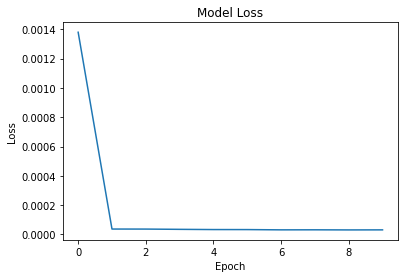

In [ ]:
# Plot the model loss
def plot_losses(hist):
    print('Validation lowest loss:', min(hist.history['loss']))
    plt.plot(hist.history['loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

### YOUR CODE HERE ###
plot_losses(history)

### Part d) More Advanced RNN Model (15 points)
In this part you will create an RNN model with the number of layers and architerure you prefer. Train it on your training data. You will also plot training and validation loss. Again, use mean squared error as your metric. In this part, you can try different models and use different hyper-parameters and report only the best one.

Compile your model and display the summary:

In [ ]:
# model = Sequential()
# model.add(LSTM(4, return_sequences=True, input_shape=(1, time_steps)))
# model.add(Dropout(0.5))
# model.add(Dense(5, activation = 'sigmoid'))
# model.add(Dropout(0.4))
# model.add(Dense(3, activation = 'sigmoid'))
# model.add(Dropout(0.25))
# model.add(Dense(1, activation = 'tanh'))

model = Sequential()
model.add(Bidirectional(LSTM(10, return_sequences=True),
                             input_shape=(1, time_steps)))
model.add(Dense(70))
model.add(Dropout(0.75))
model.add(LSTM(5, return_sequences=False))
model.add(Dense(50))
model.add(Dropout(0.5))
model.add(Dense(30))
model.add(Dropout(0.25))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss = 'mean_squared_error',
              optimizer = 'adam',
              metrics=[
                  metrics.MeanSquaredError(),
              ]
)

In [ ]:
history = model.fit(X_train,
                    y_train,
                    epochs = 25,
                    batch_size = 1,
                    validation_split= 0.2,
                    verbose = 2
)

Epoch 1/25
1672/1672 - 14s - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 3.6028e-04 - val_mean_squared_error: 3.6028e-04 - 14s/epoch - 8ms/step
Epoch 2/25
1672/1672 - 8s - loss: 6.0047e-04 - mean_squared_error: 6.0047e-04 - val_loss: 2.8919e-04 - val_mean_squared_error: 2.8919e-04 - 8s/epoch - 5ms/step
Epoch 3/25
1672/1672 - 7s - loss: 4.6969e-04 - mean_squared_error: 4.6969e-04 - val_loss: 6.8580e-05 - val_mean_squared_error: 6.8580e-05 - 7s/epoch - 4ms/step
Epoch 4/25
1672/1672 - 7s - loss: 5.5783e-04 - mean_squared_error: 5.5783e-04 - val_loss: 1.7942e-04 - val_mean_squared_error: 1.7942e-04 - 7s/epoch - 4ms/step
Epoch 5/25
1672/1672 - 9s - loss: 4.5612e-04 - mean_squared_error: 4.5612e-04 - val_loss: 1.9759e-04 - val_mean_squared_error: 1.9759e-04 - 9s/epoch - 5ms/step
Epoch 6/25
1672/1672 - 7s - loss: 4.7613e-04 - mean_squared_error: 4.7613e-04 - val_loss: 0.0023 - val_mean_squared_error: 0.0023 - 7s/epoch - 4ms/step
Epoch 7/25
1672/1672 - 7s - loss: 5.5462e-04 - mean_sq

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 1, 20)            1200      
 l)                                                              
                                                                 
 dense_1 (Dense)             (None, 1, 70)             1470      
                                                                 
 dropout (Dropout)           (None, 1, 70)             0         
                                                                 
 lstm_2 (LSTM)               (None, 5)                 1520      
                                                                 
 dense_2 (Dense)             (None, 50)                300       
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                      

Validation lowest loss: 0.00027693473384715617


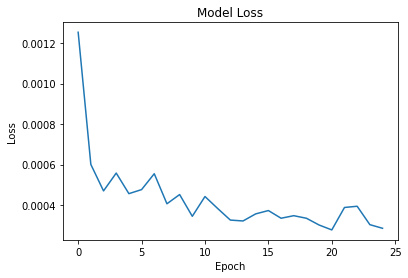

In [ ]:
plot_losses(history)

### Part e) Looking at the Predictions (10 points)
Now, Using the final (best) model you trained, show your model's performance on the test set. Plot the model's prediction for Bitcoin Price along with the actual test set prices. Lastly, note how your model's predictions change with your model's architecture and the number of days you "look back". Does your model perform better with more "look back days" or less. Did adding more layers help?

**Note:** Your model is trained on normalized data. In order to transform your model's predictions to the original price range you will likely need to use sklearn's inverse_transform (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

In [ ]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

17/17 [==============================] - 0s 6ms/step


In [ ]:
trainPredict = trainPredict.reshape(-1,1)
testPredict = testPredict.reshape(-1,1)

trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform(y_train)
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform(y_test)

testPredict[:10]

array([[9295.372],
       [9197.452],
       [9123.952],
       [9041.44 ],
       [8977.909],
       [8996.358],
       [9000.755],
       [8992.732],
       [8972.67 ],
       [8933.813]], dtype=float32)

In [ ]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(y_train[0], trainPredict[0]))
print('Train Score:', np.round(trainScore, 4), 'RMSE')
testScore = np.sqrt(mean_squared_error(y_test[0], testPredict[0]))
print('Test Score: ', np.round(testScore, 4), 'RMSE')

Train Score: 560.935 RMSE
Test Score:  245.0938 RMSE


In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(data_normalized)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_steps: len(trainPredict) + time_steps, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(data_normalized)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + time_steps: len(data_normalized) - 1, :] = testPredict

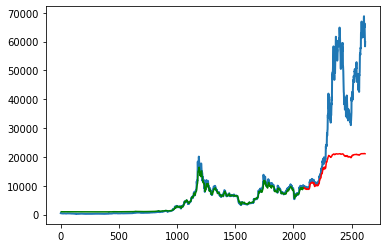

In [ ]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(data_normalized), linewidth=2)
plt.plot(trainPredictPlot, 'g')
plt.plot(testPredictPlot, 'r')
plt.show()

My model did worse everytime I tried changing specific parameters in each layer, resulting in a low decrease in the loss rate. My model performed better with more "time_steps", ended up in a decrease in test performance, but having  4 timesteps seemed to help improve my model's performance. Adding more layers did help to an extent as well, but I wasn't sure how to make it better. Dropout layers helped prevent overtraining the data, in order to help predict the huge spike in BTC value. However, I overtrained and was not able to accurately predict the BTC spike in value.

## Question 2: Reuters Topic Classification
---
We will use the [Reuters newswire](https://keras.io/api/datasets/reuters/) classification dataset, which has text paired with 46 topics as labels. You can see what these labels represent [here](https://martin-thoma.com/nlp-reuters/). You will analyze the text and classify the text into one of the 46 classes. Classes are the defined based on the following list (in the same order):
>```
['cocoa','grain','veg-oil','earn','acq','wheat','copper',
'housing','money-supply','coffee','sugar','trade','reserves',
'ship','cotton','carcass','crude','nat-gas','cpi','money-fx',
'interest','gnp','meal-feed','alum','oilseed','gold','tin',
'strategic-metal','livestock','retail','ipi','iron-steel',
'rubber','heat','jobs','lei','bop','zinc','orange',
'pet-chem','dlr','gas','silver','wpi','hog','lead']
```



### Part a) Processing the Data (5 points)
Load the data simply from Keras: https://www.tensorflow.org/api_docs/python/tf/keras/datasets/reuters/load_data.
You also need to follow the RNN handout from the class exercise and prepare encoding and decoding functions and any other pre-processing you might find useful.

Print 5 examples of news along with their class label. 

In [ ]:
# Load data
from keras.datasets import reuters

### YOUR CODE HERE ###
(Xtrain, ytrain), (Xtest, ytest)= tf.keras.datasets.reuters.load_data(
    path='reuters.npz',
    num_words=None,
    skip_top=0,
    maxlen=None,
    test_split=0.2,
    seed=113,
    start_char=1,
    oov_char=2,
    index_from=3,
)

#to make sure dataset is loaded correctly
print((len(ytrain)))
print((len(ytest)))
print(np.max(ytrain)+1)

# Clean and pre-process the data

### YOUR CODE HERE ###
word_dict = reuters.get_word_index() 

for i in range(50):
  for key, value in word_dict.items(): 
    if value == i:
        print('(', key, ',', value, ')', sep = '', end = ',')

word_dict = {k:(v+3) for k,v in word_dict.items()}
word_dict["<PAD>"] = 0
word_dict["<START>"] = 1
word_dict["<UNK>"] = 2
word_dict["<UNUSED>"] = 3

# Print sample data

### YOUR CODE HERE ###
vocab_size = len(word_dict.keys())
print('Number of words in vocabulary: ', vocab_size)
for i in range(25):
  for key, value in word_dict.items(): 
    if value == i:
        print('(', key, ',', value, ')', sep = '', end = ',')

8982
2246
46
(the,1),(of,2),(to,3),(in,4),(said,5),(and,6),(a,7),(mln,8),(3,9),(for,10),(vs,11),(dlrs,12),(it,13),(reuter,14),(000,15),(1,16),(pct,17),(on,18),(from,19),(is,20),(that,21),(its,22),(cts,23),(by,24),(at,25),(year,26),(be,27),(with,28),(2,29),(will,30),(was,31),(billion,32),(he,33),(u,34),(s,35),(net,36),(has,37),(would,38),(an,39),(as,40),(5,41),(not,42),(loss,43),(4,44),(1986,45),(company,46),(which,47),(but,48),(this,49),Number of words in vocabulary:  30983
(<PAD>,0),(<START>,1),(<UNK>,2),(<UNUSED>,3),(the,4),(of,5),(to,6),(in,7),(said,8),(and,9),(a,10),(mln,11),(3,12),(for,13),(vs,14),(dlrs,15),(it,16),(reuter,17),(000,18),(1,19),(pct,20),(on,21),(from,22),(is,23),(that,24),

### Part b) Data Partitioning (5 points)

Split data into train and test sets. Please use 80% for training and 20% for testing. Note that we want to have the same distribution of labels in the training and test set, so you can use stratified train-test split of Keras. See here: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [ ]:
### YOUR CODE HERE ###
Xtrain, Xtest, ytrain, ytest = train_test_split(Xtrain, 
                                                ytrain, 
                                                test_size = 0.2, 
                                                stratify = ytrain,
                                                random_state=42)

### Part c) Simple RNN Model (15 points)

Create a model using an RNN layer (LSTM or GRU, unidirectional or bidirectional) and train it on your training data. You will also plot training and validation loss and your accuracy metric.

Compile your model and display the summary:

In [ ]:
# Build your model

### YOUR CODE HERE ###
input_layer = Input(shape=(1,4))
x = Dense(1024, activation='relu')(input_layer)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(46, activation='softmax')(x)

reuters_model = Model(input_layer, x)

# reuters_model = Sequential()
# reuters_model.add(Dense(100, input_dim=(1,4), activation='relu'))
# reuters_model.add(Dense(50, activation='relu'))
# reuters_model.add(Dense(46, activation='softmax'))

reuters_model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

reuters_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 4)]            0         
                                                                 
 dense_6 (Dense)             (None, 1, 1024)           5120      
                                                                 
 dense_7 (Dense)             (None, 1, 1024)           1049600   
                                                                 
 dense_8 (Dense)             (None, 1, 512)            524800    
                                                                 
 dense_9 (Dense)             (None, 1, 256)            131328    
                                                                 
 dense_10 (Dense)            (None, 1, 128)            32896     
                                                                 
 dense_11 (Dense)            (None, 1, 64)             8256  

In [ ]:
batchsize = 1
epochs =  10

# Fit model
history = reuters_model.fit(X_train, y_train, 
                            batch_size=batchsize, 
                            epochs=epochs, 
                            validation_split=0.2, 
                            shuffle=True
)

Epoch 1/10


InvalidArgumentError: ignored

In [ ]:
# Plot the model loss and accuracy on training and validation sets

### YOUR CODE HERE ###
plot_losses(history)

### Part d) More Advanced RNN Model (15 points)
In this part, you will create an RNN model with the number of layers and architerure you prefer. Train it on your training data. You will also plot training and validation loss and your metric. In this part, you can try different models and use different hyper-parameters and report only the best one.

Compile your model and display the summary:

In [ ]:
# Build your model

### YOUR CODE HERE ###

loss = ### YOUR CODE HERE ###

opt = ### YOUR CODE HERE ###

metrics = ### YOUR CODE HERE ###

model.compile(loss=loss,
              optimizer=opt,
              metrics=metrics)

model.summary()

In [ ]:
batchsize = ### YOUR CODE HERE ###
epochs =  ### YOUR CODE HERE ###

# Fit model
history = reuters_model.fit(X_train, y_train, batch_size=batchsize, epochs=epochs, validation_split=0.2, shuffle=True)

In [ ]:
# Plot the model loss and accuracy

### YOUR CODE HERE ###

### Part e) Looking at the Predictions (10 points)

Now, Using the final (best) model you trained, show your model's performance on the test set.
Calculate and display the prediction accuracy for all of the 46 different classes. 

In [ ]:
### YOUR CODE HERE ###